In [55]:
#!/usr/bin/env python
# coding: utf-8

%load_ext autoreload
%autoreload 2

import os, datetime
import torch, pyro, numpy as np
# torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft
import click


DEVICE = 'cuda'

from utils import *
# from network import CustomTail, CustomHead

from swyft.utils import tensor_to_array, array_to_tensor
from toolz import compose
from pyrofit.lensing.distributions import get_default_shmf

import torch, numpy as np
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
from torch import tensor
import torch.nn as nn
import torchvision.transforms.functional as TF


# @click.command()
# @click.option("--m",    type=int, default = 12,  help="Exponent of subhalo mass.")
# @click.option("--nsub", type=int, default = 1,   help="Number of subhaloes.")
# @click.option("--nsim", type=int, default = 100, help="Number of simulations to run.")

# @click.option("--nmbins",  type=int, default = 2,   help="Number of mass bins.")

# @click.option("--lr",         type=float, default = 1e-3, help="Learning rate.")
# @click.option("--factor",     type=float, default = 1e-1, help = "Factor of Scheduler")
# @click.option("--patience",   type=int,   default = 5,    help = "Patience of Scheduler")
# @click.option("--max_epochs", type=int,   default = 30,   help = "Max number of epochs.")



m = 0
nsub = 3
nsim = 200

nmbins = 2

lr = 1e-3
factor = 1e-1
patience = 5
max_epochs = 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
from swyft.networks.standardization import (
    OnlineDictStandardizingLayer,
    OnlineStandardizingLayer,
)
from swyft.types import Array, MarginalIndex, ObsShapeType
from typing import Dict, Hashable, Tuple


In [56]:
time_start = datetime.datetime.now()

# Set definitions (should go to click)
system_name = "ngc4414"

# Set utilities
sim_name, sim_path = get_sim_path(m, nsub, nsim, system_name)
store = swyft.Store.load(path=sim_path)
print(f'Store has {len(store)} simulations.')

# torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
CONFIG = get_config(system_name, str(nsub), str(m))
# torch.set_default_tensor_type(torch.FloatTensor)

prior, n_pars, lows, highs = get_prior(CONFIG)
L = CONFIG.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

# Set up posterior
# torch.set_default_tensor_type(torch.FloatTensor)
dataset = swyft.Dataset(nsim, prior, store)#, simhook = noise)
# marginals = [i for i in range(L**2)]
# post = swyft.Posteriors(dataset)

Store _M_m0_nsub3_nsim200 exists!
Loading existing store.
Store has 208 simulations.
Image has L = 40.


In [57]:
# Train
mre_name, mre_path = get_mre_path(sim_name, nmbins, lr, factor, patience)

# post_name, post_path = get_post_path(sim_name, nmbins, lr, factor, patience)
print(f'Training {mre_name}!')

Training UNet_M_m0_nsub3_nsim200_nmbins2_lr-3.0_fac-1.0_pat5.pt!


n_marginals 9
n_observation_features tensor(1600)
par.shape torch.Size([100, 9])
ret.shape torch.Size([100, 9])
coord_v shape before squeeze(2) torch.Size([100, 9])
coord_v shape after squeeze(2) torch.Size([100, 9])
par.shape torch.Size([100, 9])
ret.shape torch.Size([100, 9])
coord_v shape before squeeze(2) torch.Size([100, 9])
coord_v shape after squeeze(2) torch.Size([100, 9])
par.shape torch.Size([100, 9])
ret.shape torch.Size([100, 9])
coord_v shape before squeeze(2) torch.Size([100, 9])
coord_v shape after squeeze(2) torch.Size([100, 9])
par.shape torch.Size([44, 9])
ret.shape torch.Size([44, 9])
coord_v shape before squeeze(2) torch.Size([44, 9])
coord_v shape after squeeze(2) torch.Size([44, 9])
training: lr=0.0005, epoch=1, validation loss=4436par.shape torch.Size([100, 9])
ret.shape torch.Size([100, 9])
coord_v shape before squeeze(2) torch.Size([100, 9])
coord_v shape after squeeze(2) torch.Size([100, 9])
par.shape torch.Size([100, 9])
ret.shape torch.Size([100, 9])
coord_v

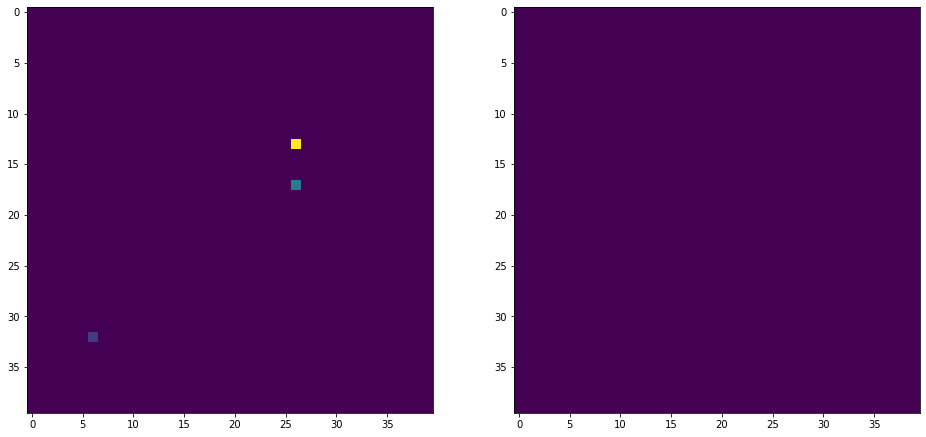

In [121]:
class Mapping:
    def __init__(self, nmbins, L, lows, highs):
        self.nmbins = nmbins
        self.L   = L
        self.lows = lows
        self.highs = highs
        
    def v_to_grid(self, coord_v):
        
        print('coord_v shape before squeeze(2)', coord_v.shape)
#         coord_v = coord_v.squeeze(2)
        coord_v = coord_v
        print('coord_v shape after squeeze(2)', coord_v.shape)
      
        coorv_v10 = torch.clone(coord_v)
        
        # Transform all masses from e.g. 10^8.5 to 8.5 so they are aligned with the highs and lows
        coorv_v10[:,2::3] = torch.log10(coorv_v10[:,2::3])
        
        n = len(coord_v[0])/3
        assert n.is_integer()
        n = int(n)
          
        lows = np.full(coord_v.shape, np.tile(self.lows, n))
        highs = np.full(coord_v.shape, np.tile(self.highs, n))   
        
        grid = lambda v: (v - lows) / (highs - lows)
        coord_grid = grid(coorv_v10)
        
        
        return coord_grid

    def coord_to_map(self, coord_v):        
         
        coord_grid = self.v_to_grid(coord_v)
        
        n_batch =  coord_grid.shape[0]
        n_coords = coord_grid.shape[1]*2/3
        assert n_coords.is_integer()

        z = torch.zeros((n_batch, self.nmbins, self.L, self.L), device = DEVICE)

                
        if not (n_batch == 0 or n_coords == 0):
            
            x_grid, y_grid, m_grid = coord_grid.view(-1,3).T.to(DEVICE)            

            x_i = torch.floor((x_grid * self.L).flatten()).type(torch.long) 
            y_i = torch.floor((y_grid * self.L).flatten()).type(torch.long) 
            m_i = torch.floor( m_grid * self.nmbins).type(torch.long) 
            b_i   = torch.floor(torch.arange(0, n_batch, 1/n_coords*2).to(DEVICE)).type(torch.long)

            z[tuple(torch.stack((b_i, m_i, y_i, x_i)))] = 1
            
        return z



class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), # bias = False becaise BatchNorm2d is set
            nn.BatchNorm2d(out_channels), # BatchNorm2d were not known when paper came out
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels, out_channels, features = [64, 128, 256, 512]):
        super(UNET, self).__init__()
                
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # keep size the same
        

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        

    def forward(self, x):
                
        x = x.unsqueeze(1)
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse list

        # the upsampling
        for idx in range(0, len(self.ups), 2): # step of 2 because we want up - double column - up - double column
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2] # //2 because we want still steps of one

            # if statement because we can put in shapes that are not divisble by two around 19:00 of video
            if x.shape != skip_connection.shape: 
                x = TF.resize(x, size=skip_connection.shape[2:]) # hopefully does not impact accuracy too much

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        return x

class CustomObservationTransform(torch.nn.Module):
    def __init__(self, observation_key: str, observation_shapes: dict):
        super().__init__()
        self.observation_key = observation_key
        self.n_features = torch.prod(tensor(observation_shapes[observation_key]))

    def forward(self, obs: dict) -> torch.Tensor:      
        x = obs
        x = x[self.observation_key]
        x = x.view(len(x), self.n_features)
        return x

class CustomMarginalClassifier(torch.nn.Module):
    def __init__(self, n_marginals: int, n_combined_features: int):
        super().__init__()
                
        self.n_marginals = n_marginals
        self.n_combined_features = n_combined_features
        
        self.n_features = 1600 #n_features
        self.L = int(np.sqrt(self.n_features).item())
        self.nmbins = 2 #tail_args['nmbins']
        self.lows   = lows #tail_args['lows']
        self.highs  = highs #tail_args['highs']
        self.out_channels = self.nmbins
        
        self.Map  = Mapping(self.nmbins, self.L, self.lows, self.highs)
        self.UNet = UNET(in_channels = 1, out_channels = self.out_channels)
                
    def forward(
        self, features: torch.Tensor, marginal_block: torch.Tensor
    ) -> torch.Tensor:
        sims = features
        target = marginal_block
    
        sims = sims.view(-1, self.L, self.L)
        x = self.UNet(sims)
        z = self.Map.coord_to_map(target)
        
        x = x * z
        x = x.view(-1, self.n_features * self.out_channels)
        
        return x
    
class CustomParameterTransform(nn.Module):
    def __init__(
        self, n_parameters: int, marginal_indices: MarginalIndex, online_z_score: bool
    ) -> None:
        super().__init__()
        self.n_parameters = torch.Size([n_parameters])
        if online_z_score:
            self.online_z_score = OnlineStandardizingLayer(self.n_parameters)
        else:
            self.online_z_score = nn.Identity()

    def forward(self, parameters: torch.Tensor) -> torch.Tensor:
        parameters = self.online_z_score(parameters)
#         print('paremeters', parameters.unsqueeze(2).shape)
#         ret = parameters.unsqueeze(2)
        ret = parameters
        print('par.shape', parameters.shape)
        print('ret.shape', ret.shape)
        return ret



    
def get_custom_marginal_classifier(
    observation_transform,
    marginal_indices: tuple,
    n_parameters: int,
    marginal_classifier,
    parameter_online_z_score: bool = False
) -> torch.nn.Module:
    n_observation_features = observation_transform.n_features
    
    parameter_transform = CustomParameterTransform(
        n_parameters, marginal_indices, online_z_score=parameter_online_z_score
    )
    
#     n_marginals, n_block_parameters = parameter_transform.marginal_block_shape
    n_marginals = 9
    
    print('n_marginals', n_marginals)
#     print('n_block_parameters param', n_block_parameters)
    print('n_observation_features', n_observation_features)

    marginal_classifier = marginal_classifier(
        n_marginals,
        n_observation_features# + n_block_parameters,
    )

    return swyft.networks.Network(
        observation_transform,
        parameter_transform,
        marginal_classifier,
    )
    

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    n_parameters= n_pars,
    marginal_classifier = CustomMarginalClassifier,
)

mre = swyft.MarginalRatioEstimator(
    marginal_indices = marginal_indices,
    network = network,
    device = DEVICE,
)

_ = mre.train(dataset, max_epochs = 3)

mre.save(mre_path)

plt_imshow(mre_loaded.network(obs0, v0).view(2, L, L))

par.shape torch.Size([1, 4800])
ret.shape torch.Size([1, 4800])
coord_v shape before squeeze(2) torch.Size([1, 4800])
coord_v shape after squeeze(2) torch.Size([1, 4800])


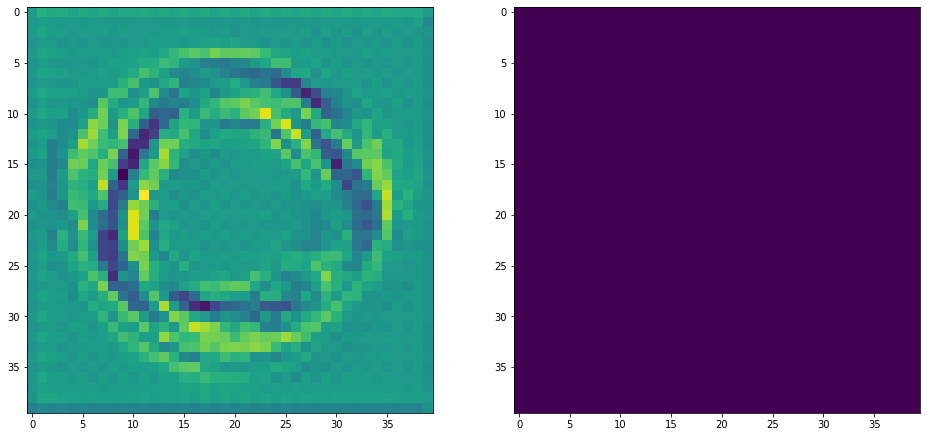

par.shape torch.Size([1, 4800])
ret.shape torch.Size([1, 4800])
coord_v shape before squeeze(2) torch.Size([1, 4800])
coord_v shape after squeeze(2) torch.Size([1, 4800])


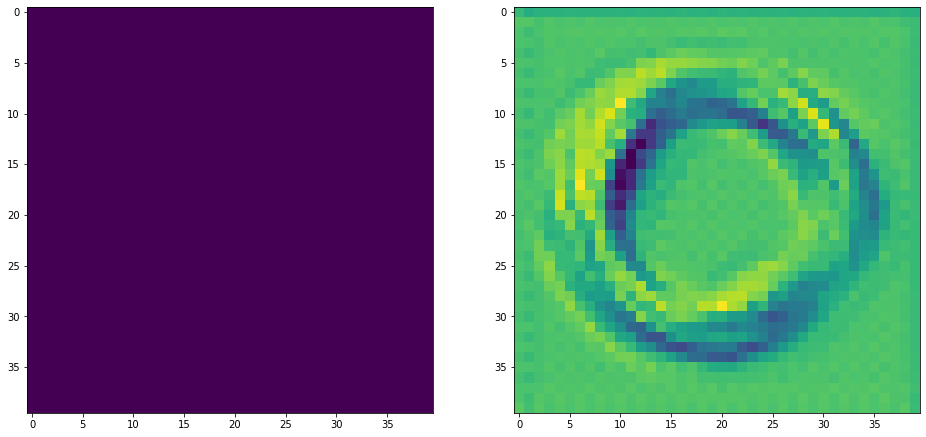

par.shape torch.Size([1, 0])
ret.shape torch.Size([1, 0])
coord_v shape before squeeze(2) torch.Size([1, 0])
coord_v shape after squeeze(2) torch.Size([1, 0])


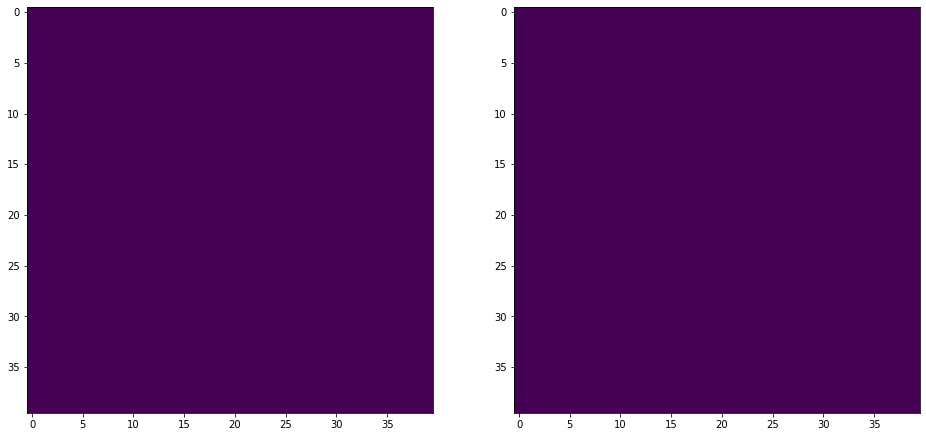

In [122]:
plt_imshow(mre.network(obs0, coords[1]).view(2, L, L))
plt_imshow(mre.network(obs0, coords[2]).view(2, L, L))
plt_imshow(mre.network(obs0, coords[0]).view(2, L, L))

paremeters torch.Size([1, 4800, 1])


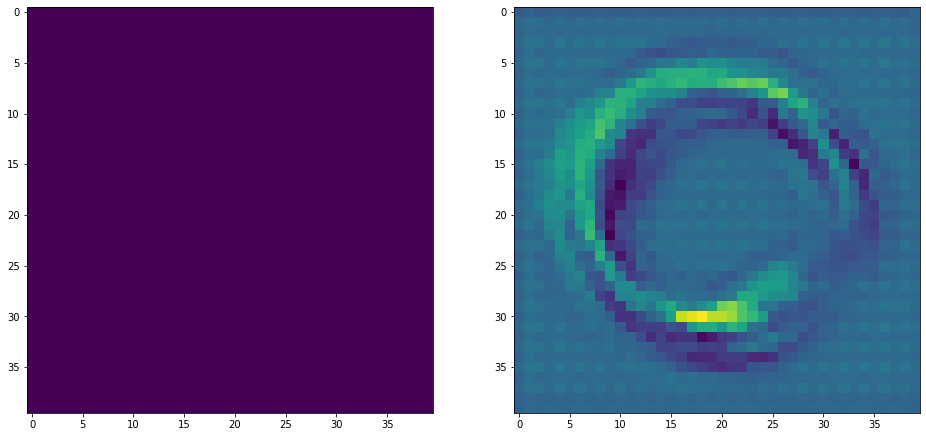

In [48]:
marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)
swyft.utils.tupleize_marginal_indices(marginal_indices)

((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,))

In [49]:
marginal_indices

((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,))

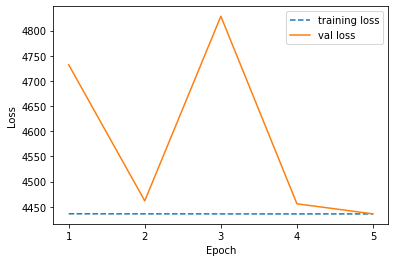

In [5]:
plot_losses(mre)

# Analyze

In [6]:
assert 1 == 2

AssertionError: 

In [65]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK


network_new = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    n_parameters= n_pars,
    marginal_classifier = CustomMarginalClassifier,
)

mre_loaded = swyft.MarginalRatioEstimator.load(
    network=network_new,
    device=DEVICE,
    filename=mre_path,
)

torch.set_default_tensor_type(torch.FloatTensor)

In [66]:
def get_coords(nmbins, L):
    grid = np.linspace(lows[0], highs[0], L, endpoint = False)
    x, y = np.meshgrid(grid, grid, indexing = 'xy')
    ms = [torch.full((L*L,), m_i) for m_i in np.logspace(lows[-1], highs[-1], 2*nmbins+1)[1::2]]

    coords = [np.array(()).reshape(1, -1)]
    for m in ms:
        coord = np.transpose(np.stack((x.flatten(), y.flatten(), m))).reshape(1, -1)
        coords.append(coord)
    return coords

coords = get_coords(nmbins, L)


In [8]:
obs0 = store[1][0]
obs0['image'] = tensor(obs0['image']).unsqueeze(0).to(DEVICE, dtype = torch.float)

In [ ]:
marginal_indices, _ = swyft.utils.get_corner_marginal_indices(4800)
torch.tensor(swyft.utils.tupleize_marginal_indices(marginal_indices))

In [ ]:
params

In [ ]:
coord = coords[1]
params = tensor(coord).to(DEVICE, dtype = torch.float)
output = mre_loaded.network(obs0, params)

# output.shape

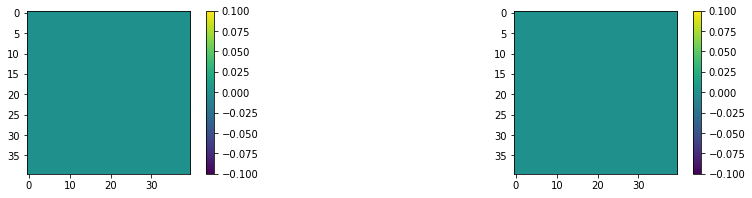

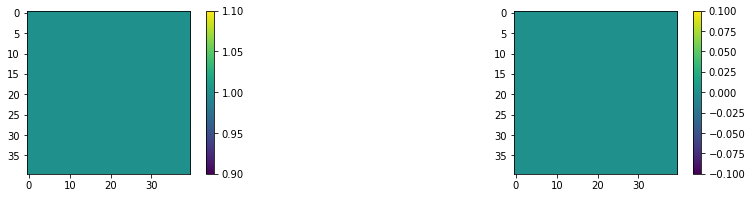

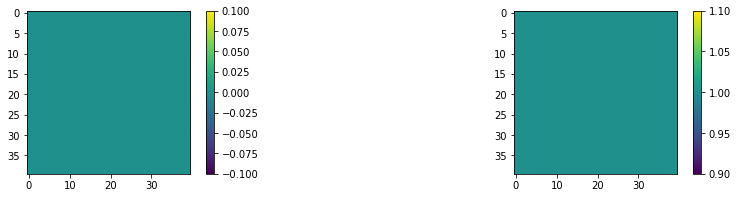

In [76]:
def get_coords(nmbins, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    ms = [torch.full((L*L,), m_i) for m_i in torch.logspace(lows[-1], highs[-1], 2*nmbins+1)[1::2]]

    coords = [torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)]
    for m in ms:
        coord = torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1).reshape(1, -1).to(DEVICE, dtype = torch.float)
        coords.append(coord)
    return coords

coords = get_coords(nmbins, L)

for coord in coords:
    target = mre_loaded.network.marginal_classifier.Map.coord_to_map(coord.unsqueeze(2)).squeeze()
    plt_imshow(target, cbar = True, size_y = 3)

In [95]:
tensor([[ 7.7780e-01, -8.2849e-01,  1.2523e+09, -1.6596e+00,  1.5642e+00,
          3.7644e+08,  8.0977e-01, -3.6326e-01,  1.1225e+09]], device='cuda:0',
       dtype=torch.float64).unsqueeze(0)

tensor([[[ 7.7780e-01, -8.2849e-01,  1.2523e+09, -1.6596e+00,  1.5642e+00,
           3.7644e+08,  8.0977e-01, -3.6326e-01,  1.1225e+09]]],
       device='cuda:0', dtype=torch.float64)

parameters tensor([[ 7.7780e-01, -8.2849e-01,  1.2523e+09, -1.6596e+00,  1.5642e+00,
          3.7644e+08,  8.0977e-01, -3.6326e-01,  1.1225e+09]], device='cuda:0',
       dtype=torch.float64)
ret forward tensor([[[ 7.7780e-01],
         [-8.2849e-01],
         [ 1.2523e+09],
         [-1.6596e+00],
         [ 1.5642e+00],
         [ 3.7644e+08],
         [ 8.0977e-01],
         [-3.6326e-01],
         [ 1.1225e+09]]], device='cuda:0', dtype=torch.float64)


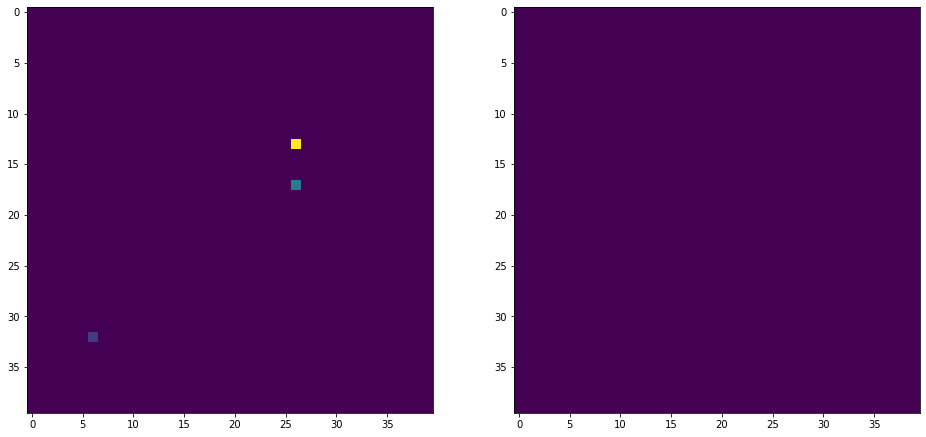

In [93]:
plt_imshow(mre_loaded.network(obs0, v0).view(2, L, L))

In [79]:
plt_imshow(mre_loaded.network(obs0, coords[0]).view(2, L, L))

<class 'tuple'>
<class 'tuple'>


ValueError: how did this happen?

marg_ind tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8]], device='cuda:0')


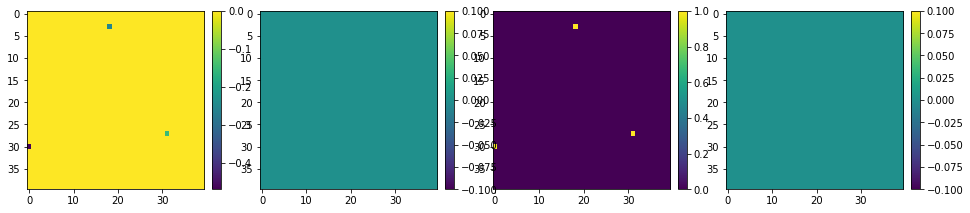

marg_ind tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8]], device='cuda:0')


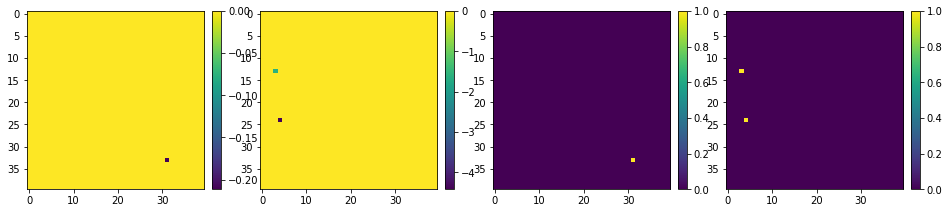

marg_ind tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8]], device='cuda:0')


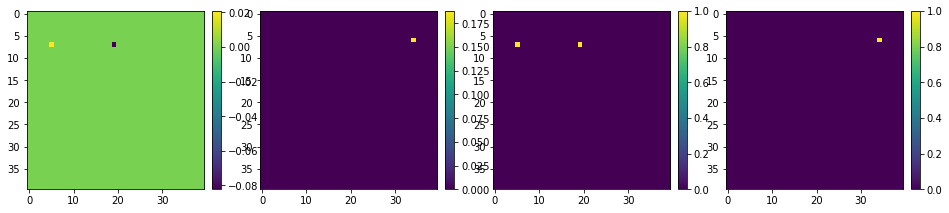

marg_ind tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8]], device='cuda:0')


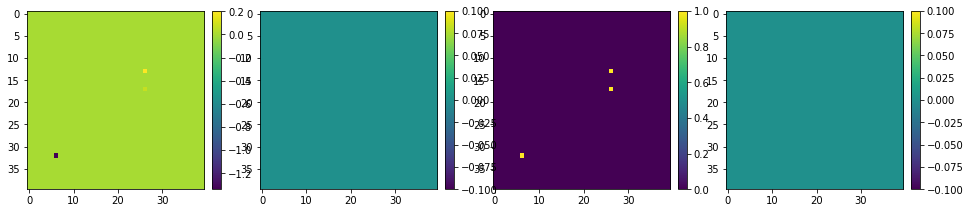

In [46]:
outputs = []
for i in np.random.randint(0, len(store), 4):
    obs0 = store[i][0]
    v0 = store[i][1]

    obs0['image'] = tensor(obs0['image']).unsqueeze(0).to(DEVICE, dtype = torch.float)
    
    v0 = tensor(v0).unsqueeze(0).to(DEVICE)
    
    output = mre_loaded.network(obs0, v0).view(2, L, L)
    target = mre.network.marginal_classifier.Map.coord_to_map(v0.unsqueeze(2)).squeeze().view(2, L, L)
    
    
    plt_imshow(torch.cat((output, target), dim = 0), cbar = True)
    
    
#     for coord in coords[1:]:
#         output = mre_loaded.network(obs0, coord)
#         outputs.append(output)

In [33]:
.shape

torch.Size([4, 40, 40])

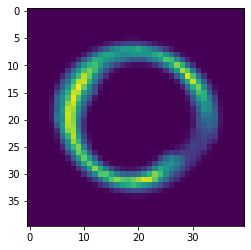

In [10]:
plt.imshow(obs0['image'].view(L, L))

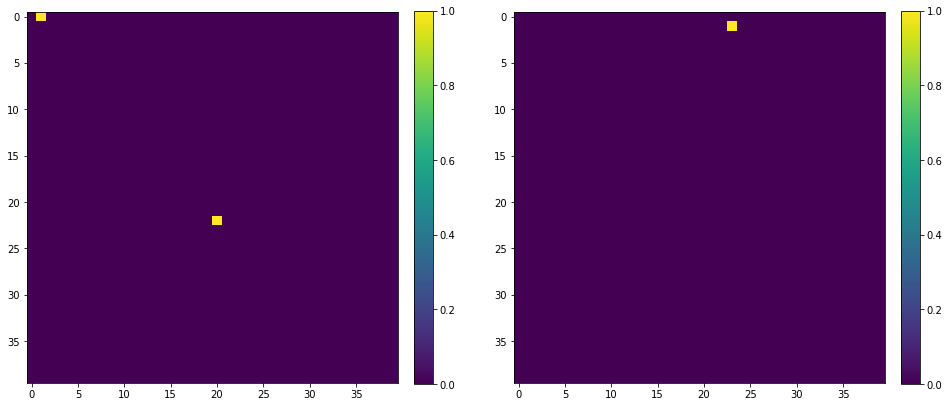

In [21]:

plt_imshow(target.view(2, L, L), cbar=True)

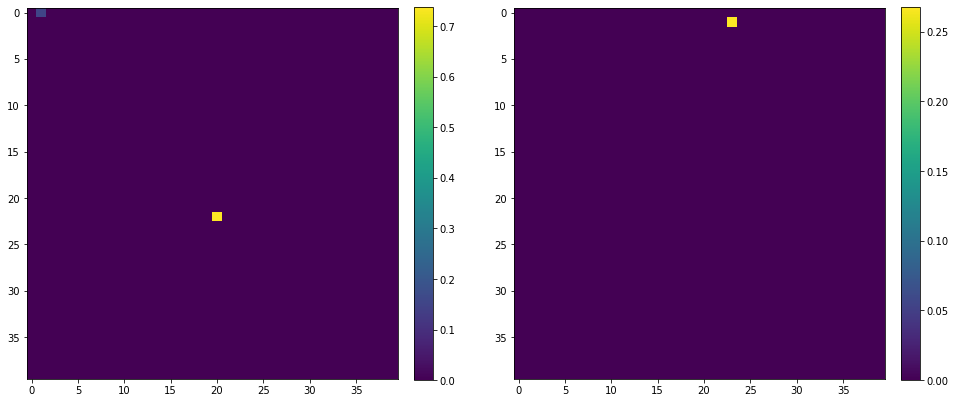

In [11]:
plt_imshow(output.view(2, L, L), cbar=True)

In [ ]:
obs0

In [ ]:
mre_loaded.network(obs0, v0).view(2, L, L)

In [ ]:
plt_imshow(mre_loaded.network(obs0, v0).view(2, L, L))

In [ ]:
plt_imshow(outputs[1].view(2, L, L))

In [ ]:
coords[1]

In [ ]:
coords[0], coords[0].shape, coords[1].shape

In [ ]:
mre_loaded.network(obs0, coords[0])

In [ ]:
# plt_imshow( output.view(nmbins, L, L) )